# 01 - Data Preparation and Cleaning

This notebook handles:
- Data loading and validation
- Schema checking and data types
- Missing values assessment and handling
- Outlier detection and treatment
- Data Quality Report generation

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load datasets exactly like the R documentation
d1 = pd.read_csv(r"../data/raw/student-mat.csv", sep=";")
d2 = pd.read_csv(r"../data/raw/student-por.csv", sep=";")

# Merge on demographic variables (same as R code)
merge_keys = [
    "school",
    "sex",
    "age",
    "address",
    "famsize",
    "Pstatus",
    "Medu",
    "Fedu",
    "Mjob",
    "Fjob",
    "reason",
    "nursery",
    "internet",
]

d3 = pd.merge(d1, d2, on=merge_keys, how="inner", suffixes=("_math", "_por"))
print(f"Merged students: {len(d3)}")  # Should be 382 like R code

# For analysis, use concatenated data (each student appears once per subject)
df = pd.concat([d1, d2], axis=0, ignore_index=True)
print(f"Total dataset shape: {df.shape}")
df.head()

Merged students: 382
Total dataset shape: (1044, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

In [59]:
print(df.dtypes)

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object


In [60]:
# Student Dataset Variable Type Conversions

# KEEP AS NUMERIC (continuous/count variables)
# These should stay as int64/float64
numeric_vars = [
    "age",  # Continuous: 15-22 years
    "failures",  # Count: 0-4 failures
    "absences",  # Count: 0-93 absences
    "G1",
    "G2",
    "G3",  # Continuous: 0-20 grade scale
]

# CONVERT TO ORDERED CATEGORICAL (ordinal scales)
# These have meaningful order/ranking

# Education levels (0=none, 1=primary, 2=5th-9th, 3=secondary, 4=higher)
df["Medu"] = pd.Categorical(df["Medu"], categories=[0, 1, 2, 3, 4], ordered=True)
df["Fedu"] = pd.Categorical(df["Fedu"], categories=[0, 1, 2, 3, 4], ordered=True)

# Time/frequency scales
df["traveltime"] = pd.Categorical(
    df["traveltime"], categories=[1, 2, 3, 4], ordered=True
)  # <15min to >1hour
df["studytime"] = pd.Categorical(
    df["studytime"], categories=[1, 2, 3, 4], ordered=True
)  # <2h to >10h

# Quality/quantity scales (1=very low/bad to 5=very high/good)
df["famrel"] = pd.Categorical(df["famrel"], categories=[1, 2, 3, 4, 5], ordered=True)
df["freetime"] = pd.Categorical(
    df["freetime"], categories=[1, 2, 3, 4, 5], ordered=True
)
df["goout"] = pd.Categorical(df["goout"], categories=[1, 2, 3, 4, 5], ordered=True)
df["Dalc"] = pd.Categorical(df["Dalc"], categories=[1, 2, 3, 4, 5], ordered=True)
df["Walc"] = pd.Categorical(df["Walc"], categories=[1, 2, 3, 4, 5], ordered=True)
df["health"] = pd.Categorical(df["health"], categories=[1, 2, 3, 4, 5], ordered=True)

# CONVERT TO REGULAR CATEGORICAL (nominal - no meaningful order)
nominal_vars = [
    "sex",
    "school",  # GP or MS
    "address",  # U or R
    "famsize",  # LE3 or GT3
    "Pstatus",  # T or A
    "Mjob",  # teacher, health, services, at_home, other
    "Fjob",  # teacher, health, services, at_home, other
    "guardian",  # mother, father, other
    "reason",  # home, reputation, course, other
]

for var in nominal_vars:
    df[var] = df[var].astype("category")

# CONVERT TO BOOLEAN (binary yes/no variables)
binary_vars = [
    "schoolsup",
    "famsup",
    "paid",
    "activities",
    "nursery",
    "higher",
    "internet",
    "romantic",
]

for var in binary_vars:
    # Convert 'yes'/'no' strings to boolean
    df[var] = df[var] == "yes"

# VERIFY CONVERSIONS
print("=== DATA TYPES AFTER CONVERSION ===")
print(df.dtypes)

=== DATA TYPES AFTER CONVERSION ===
school        category
sex           category
age              int64
address       category
famsize       category
Pstatus       category
Medu          category
Fedu          category
Mjob          category
Fjob          category
reason        category
guardian      category
traveltime    category
studytime     category
failures         int64
schoolsup         bool
famsup            bool
paid              bool
activities        bool
nursery           bool
higher            bool
internet          bool
romantic          bool
famrel        category
freetime      category
goout         category
Dalc          category
Walc          category
health        category
absences         int64
G1               int64
G2               int64
G3               int64
dtype: object


In [61]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [72]:
df.duplicated().sum()

np.int64(0)

## 🔍 Categorical Variables Analysis

**Critical**: Understanding ordinal vs nominal features affects validation, outlier detection, and later preprocessing choices.

In [63]:
# Define feature types based on domain knowledge
ordinal_features = {
    "Medu": [0, 1, 2, 3, 4],  # Mother's education (none to higher)
    "Fedu": [0, 1, 2, 3, 4],  # Father's education (none to higher)
    "traveltime": [1, 2, 3, 4],  # Travel time (<15min to >1hour)
    "studytime": [1, 2, 3, 4],  # Study time (<2h to >10h)
    "failures": [0, 1, 2, 3, 4],  # Number of failures (0 to 3+)
    "famrel": [1, 2, 3, 4, 5],  # Family relationship (very bad to excellent)
    "freetime": [1, 2, 3, 4, 5],  # Free time (very low to very high)
    "goout": [1, 2, 3, 4, 5],  # Going out (very low to very high)
    "Dalc": [1, 2, 3, 4, 5],  # Workday alcohol (very low to very high)
    "Walc": [1, 2, 3, 4, 5],  # Weekend alcohol (very low to very high)
    "health": [1, 2, 3, 4, 5],  # Health status (very bad to very good)
}

nominal_features = [
    "school",
    "sex",
    "address",
    "famsize",
    "Pstatus",
    "Mjob",
    "Fjob",
    "reason",
    "guardian",
    "schoolsup",
    "famsup",
    "paid",
    "activities",
    "nursery",
    "higher",
    "internet",
    "romantic",
]

print("🔢 Ordinal Features (with meaningful order):")
for feature, values in ordinal_features.items():
    print(f"  {feature}: {values}")

print(f"\n📝 Nominal Features (no meaningful order): {len(nominal_features)}")
print(f"  {nominal_features}")

🔢 Ordinal Features (with meaningful order):
  Medu: [0, 1, 2, 3, 4]
  Fedu: [0, 1, 2, 3, 4]
  traveltime: [1, 2, 3, 4]
  studytime: [1, 2, 3, 4]
  failures: [0, 1, 2, 3, 4]
  famrel: [1, 2, 3, 4, 5]
  freetime: [1, 2, 3, 4, 5]
  goout: [1, 2, 3, 4, 5]
  Dalc: [1, 2, 3, 4, 5]
  Walc: [1, 2, 3, 4, 5]
  health: [1, 2, 3, 4, 5]

📝 Nominal Features (no meaningful order): 17
  ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [64]:
# ORDINAL-SPECIFIC VALIDATION
print("=== ORDINAL FEATURES VALIDATION ===")
ordinal_issues = {}

for feature, expected_values in ordinal_features.items():
    if feature in df.columns:
        actual_values = sorted(df[feature].unique())
        expected_set = set(expected_values)
        actual_set = set(actual_values)

        # Check for unexpected values (potential data entry errors)
        unexpected = actual_set - expected_set
        missing_levels = expected_set - actual_set

        if unexpected or missing_levels:
            ordinal_issues[feature] = {
                "unexpected": list(unexpected),
                "missing_levels": list(missing_levels),
                "actual_range": f"{min(actual_values)} to {max(actual_values)}",
            }

        print(f"\n{feature}:")
        print(f"  Expected: {expected_values}")
        print(f"  Actual: {actual_values}")
        if unexpected:
            print(f"  ⚠️  UNEXPECTED VALUES: {list(unexpected)}")
        if missing_levels:
            print(f"  ℹ️  Missing levels: {list(missing_levels)}")

if ordinal_issues:
    print(f"\n🚨 Found issues in {len(ordinal_issues)} ordinal features!")
else:
    print(f"\n✅ All ordinal features have valid value ranges")

=== ORDINAL FEATURES VALIDATION ===

Medu:
  Expected: [0, 1, 2, 3, 4]
  Actual: [0, 1, 2, 3, 4]

Fedu:
  Expected: [0, 1, 2, 3, 4]
  Actual: [0, 1, 2, 3, 4]

traveltime:
  Expected: [1, 2, 3, 4]
  Actual: [1, 2, 3, 4]

studytime:
  Expected: [1, 2, 3, 4]
  Actual: [1, 2, 3, 4]

failures:
  Expected: [0, 1, 2, 3, 4]
  Actual: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
  ℹ️  Missing levels: [4]

famrel:
  Expected: [1, 2, 3, 4, 5]
  Actual: [1, 2, 3, 4, 5]

freetime:
  Expected: [1, 2, 3, 4, 5]
  Actual: [1, 2, 3, 4, 5]

goout:
  Expected: [1, 2, 3, 4, 5]
  Actual: [1, 2, 3, 4, 5]

Dalc:
  Expected: [1, 2, 3, 4, 5]
  Actual: [1, 2, 3, 4, 5]

Walc:
  Expected: [1, 2, 3, 4, 5]
  Actual: [1, 2, 3, 4, 5]

health:
  Expected: [1, 2, 3, 4, 5]
  Actual: [1, 2, 3, 4, 5]

🚨 Found issues in 1 ordinal features!


### It is normal to not have students with 3 or more failed classes

In [65]:
# 🚨 NOMINAL-SPECIFIC VALIDATION
print("\n=== NOMINAL FEATURES VALIDATION ===")

# Expected values for nominal features (from dataset documentation)
nominal_expected = {
    "school": ["GP", "MS"],
    "sex": ["F", "M"],
    "address": ["U", "R"],
    "famsize": ["LE3", "GT3"],
    "Pstatus": ["T", "A"],
    "Mjob": ["teacher", "health", "services", "at_home", "other"],
    "Fjob": ["teacher", "health", "services", "at_home", "other"],
    "reason": ["home", "reputation", "course", "other"],
    "guardian": ["mother", "father", "other"],
    "schoolsup": ["yes", "no"],
    "famsup": ["yes", "no"],
    "paid": ["yes", "no"],
    "activities": ["yes", "no"],
    "nursery": ["yes", "no"],
    "higher": ["yes", "no"],
    "internet": ["yes", "no"],
    "romantic": ["yes", "no"],
}

nominal_issues = {}
for feature in nominal_features:
    if feature in df.columns:
        actual_values = sorted(df[feature].unique())

        # Check for potential typos/case issues
        if feature in nominal_expected:
            expected = set(nominal_expected[feature])
            actual = set(actual_values)
            unexpected = actual - expected

            if unexpected:
                nominal_issues[feature] = list(unexpected)

        print(f"\n{feature}: {actual_values}")
        if feature in nominal_issues:
            print(f"  ⚠️  UNEXPECTED: {nominal_issues[feature]}")

if nominal_issues:
    print(
        f"\n🚨 Found potential typos/encoding issues in {len(nominal_issues)} nominal features!"
    )
else:
    print(f"\n✅ All nominal features have expected categories")


=== NOMINAL FEATURES VALIDATION ===

school: ['GP', 'MS']

sex: ['F', 'M']

address: ['R', 'U']

famsize: ['GT3', 'LE3']

Pstatus: ['A', 'T']

Mjob: ['at_home', 'health', 'other', 'services', 'teacher']

Fjob: ['at_home', 'health', 'other', 'services', 'teacher']

reason: ['course', 'home', 'other', 'reputation']

guardian: ['father', 'mother', 'other']

schoolsup: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

famsup: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

paid: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

activities: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

nursery: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

higher: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

internet: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

romantic: [np.False_, np.True_]
  ⚠️  UNEXPECTED: [np.False_, np.True_]

🚨 Found potential typos/encoding issues in 8 nominal features!


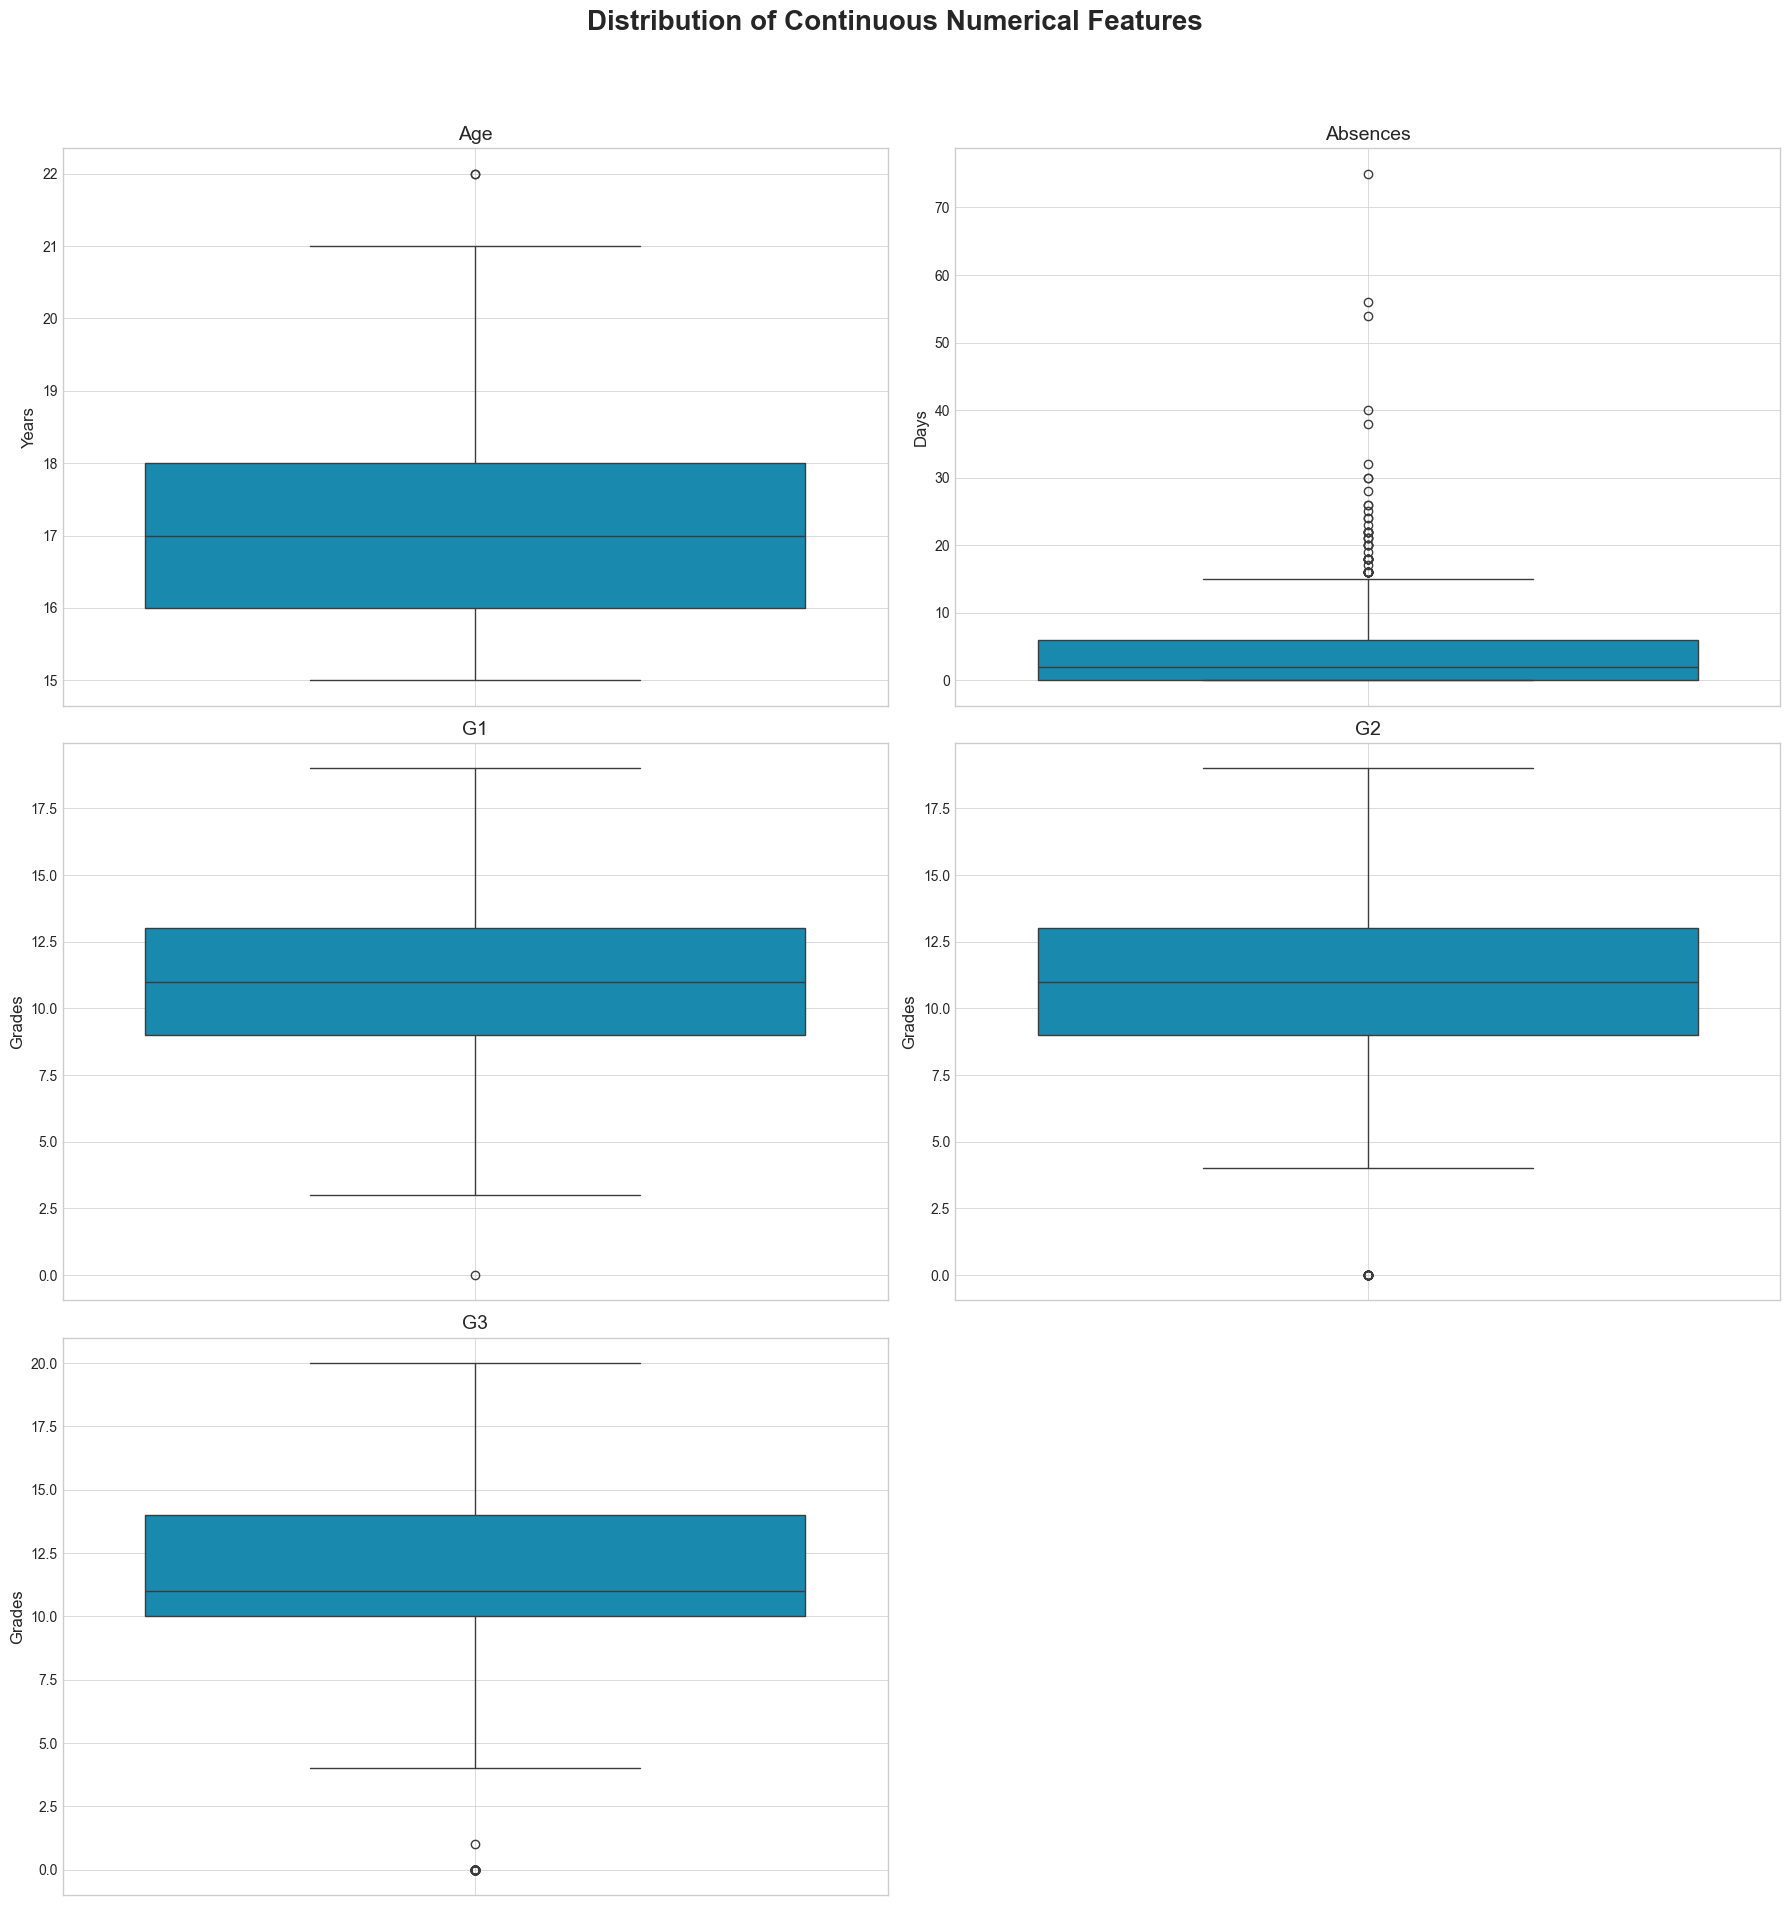

In [66]:
continuous_features = ["age", "absences", "G1", "G2", "G3"]

plt.style.use("seaborn-v0_8-whitegrid")

fig, axs = plt.subplots(3, 2, figsize=(18, 20))

# Main title for the figure
fig.suptitle(
    "Distribution of Continuous Numerical Features", fontsize=20, fontweight="bold"
)

# Boxplot for TotalCharges
sns.boxplot(data=df, y=continuous_features[0], ax=axs[0, 0], color="#0096c7")
axs[0, 0].set_title("Age", fontsize=14)
axs[0, 0].set_ylabel("Years", fontsize=12)
axs[0, 0].grid(True, which="both", linewidth=0.5)


# Boxplot for MonthlyCharges
sns.boxplot(data=df, y=continuous_features[1], ax=axs[0, 1], color="#0096c7")
axs[0, 1].set_title("Absences", fontsize=14)
axs[0, 1].set_ylabel("Days", fontsize=12)
axs[0, 1].grid(True, which="both", linewidth=0.5)

sns.boxplot(data=df, y=continuous_features[2], ax=axs[1, 0], color="#0096c7")
axs[1, 0].set_title("G1", fontsize=14)
axs[1, 0].set_ylabel("Grades", fontsize=12)
axs[1, 0].grid(True, which="both", linewidth=0.5)

# Boxplot for G2
sns.boxplot(data=df, y=continuous_features[3], ax=axs[1, 1], color="#0096c7")
axs[1, 1].set_title("G2", fontsize=14)
axs[1, 1].set_ylabel("Grades", fontsize=12)
axs[1, 1].grid(True, which="both", linewidth=0.5)

# Boxplot for G3
sns.boxplot(data=df, y=continuous_features[4], ax=axs[2, 0], color="#0096c7")
axs[2, 0].set_title("G3", fontsize=14)
axs[2, 0].set_ylabel("Grades", fontsize=12)
axs[2, 0].grid(True, which="both", linewidth=0.5)

axs[2, 1].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## ✅ Outlier Treatment Decision

**Keep all data points** - no removal needed:
- **Age range 15-22**: Normal for secondary education, older students may be repeaters
- **Absences 0-32**: Wide range but realistic (some students may have extended absences due to health/family issues)
- **Grades (G1/G2/G3)**: Some students scored 0 (likely dropouts or severe academic difficulties) - valuable for at-risk analysis
- **No data entry errors** found in any continuous variables
- **"Outliers" represent valuable student populations**: at-risk students, adult learners, students with special circumstances
- **Preserving real-world variation** is more valuable than statistical "cleanliness" for educational intervention insights

## Feature engineering

In [67]:
# Create a binary target variable: pass (1) if G3 >= 10, else fail (0)
df["pass_fail"] = (df["G3"] >= 10).astype(int)

In [68]:
# Create attendance proxy from absences
# High attendance = Low absences, Low attendance = High absences
# Scale: 0 (worst attendance) to 100 (perfect attendance)
max_absences = df["absences"].max()
df["attendance_proxy"] = 100 * (1 - df["absences"] / max_absences)

print(f"Attendance Proxy Feature Created:")
print(
    f"- Range: {df['attendance_proxy'].min():.1f} to {df['attendance_proxy'].max():.1f}"
)
print(f"- Mean: {df['attendance_proxy'].mean():.1f}")
print(
    f"- Students with perfect attendance (100): {(df['attendance_proxy'] == 100).sum()}"
)
print(f"- Students with <50% attendance: {(df['attendance_proxy'] < 50).sum()}")

Attendance Proxy Feature Created:
- Range: 0.0 to 100.0
- Mean: 94.1
- Students with perfect attendance (100): 359
- Students with <50% attendance: 5


In [69]:
# Create average of G1-G3 for overall academic performance indicator
df["grade_average"] = (df["G1"] + df["G2"] + df["G3"]) / 3

print(f"\nGrade Average Feature Created:")
print(f"- Range: {df['grade_average'].min():.2f} to {df['grade_average'].max():.2f}")
print(f"- Mean: {df['grade_average'].mean():.2f}")
print(f"- Standard deviation: {df['grade_average'].std():.2f}")

# Show relationship with individual grades
print(f"\nCorrelations with individual grades:")
print(f"- G1: {df['grade_average'].corr(df['G1']):.3f}")
print(f"- G2: {df['grade_average'].corr(df['G2']):.3f}")
print(f"- G3: {df['grade_average'].corr(df['G3']):.3f}")


Grade Average Feature Created:
- Range: 1.33 to 19.33
- Mean: 11.27
- Standard deviation: 3.22

Correlations with individual grades:
- G1: 0.925
- G2: 0.970
- G3: 0.960


## Export dataset

In [70]:
df.to_csv("student_data_prepared.csv", index=False)

In [71]:
df.to_pickle("cleaned_dataset.pkl")